# Zero Inflated Poisson Regression Model

### The non-mathematical intuition behind the Zero Inflated Poisson model
> Normally, we assume that there is some underlying process that is producing the observed counts as per the Poisson distribution.

> The intuition behind the ZIP model is that there is a second underlying process that is determining whether a count is zero or non-zero. Once a count is determined to be non-zero, the regular Poisson process determines its actual non-zero value based on the Poisson probability distribution.

> Using "patsy" package

In [1]:
import time
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings  
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
#Reading the data

df = pd.read_csv("neurownv_by_county_2000-2018_full_(2020-02-28).csv")
print(df.columns)
print("\nShape: ", df.shape)
print("\nUnique Counties: ", df.fips.nunique())
print("\nUnique Years: ", df.year.nunique(), "\n", df.year.unique())
df.head(5)

Index(['fips', 'county', 'state', 'location', 'year', 'count'], dtype='object')

Shape:  (59052, 6)

Unique Counties:  3108

Unique Years:  19 
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


,fips,county,state,location,year,count
0,01001,Autauga,Alabama,Alabama-Autauga,2000,0
1,01001,Autauga,Alabama,Alabama-Autauga,2001,0
2,01001,Autauga,Alabama,Alabama-Autauga,2002,1
3,01001,Autauga,Alabama,Alabama-Autauga,2003,0
4,01001,Autauga,Alabama,Alabama-Autauga,2004,0


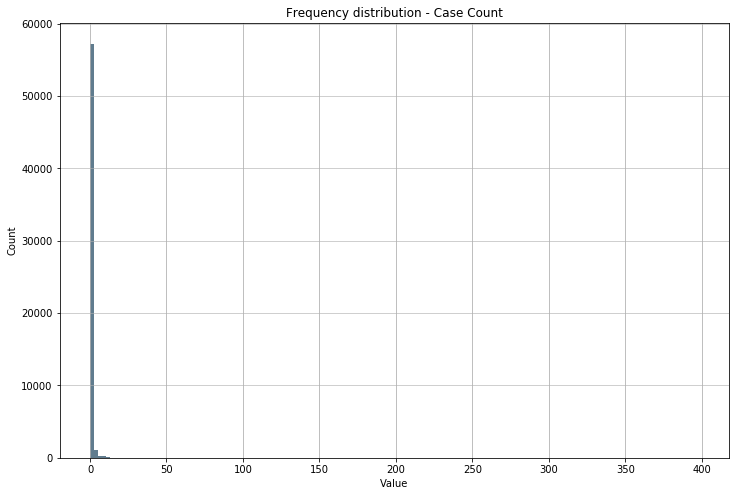

In [4]:
df['count'].plot.hist(grid=True, bins=150, rwidth=2,
                   color='#607c8e')
plt.title('Frequency distribution - Case Count')
plt.xlabel('Value')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

In [5]:
#Checking the number of zero values

(df['count'] == 0).sum()

51711

In [6]:
(df['count'] != 0).sum() #Verifying the number of non-zero values

7341

#### Dataset specific processing

In [7]:
df[df['fips'] == '46102/46113'].head()

,fips,county,state,location,year,count
45182,46102/46113,Oglala Lakota/Shannon,South Dakota,South Dakota-Oglala Lakota/Shannon,2000,0
45183,46102/46113,Oglala Lakota/Shannon,South Dakota,South Dakota-Oglala Lakota/Shannon,2001,0
45184,46102/46113,Oglala Lakota/Shannon,South Dakota,South Dakota-Oglala Lakota/Shannon,2002,0
45185,46102/46113,Oglala Lakota/Shannon,South Dakota,South Dakota-Oglala Lakota/Shannon,2003,8
45186,46102/46113,Oglala Lakota/Shannon,South Dakota,South Dakota-Oglala Lakota/Shannon,2004,0


In [8]:
df[df['fips'] == '51019/51515'].head()

,fips,county,state,location,year,count
53124,51019/51515,Bedford/Bedford City,Virginia,Virginia-Bedford/Bedford City,2000,0
53125,51019/51515,Bedford/Bedford City,Virginia,Virginia-Bedford/Bedford City,2001,0
53126,51019/51515,Bedford/Bedford City,Virginia,Virginia-Bedford/Bedford City,2002,0
53127,51019/51515,Bedford/Bedford City,Virginia,Virginia-Bedford/Bedford City,2003,1
53128,51019/51515,Bedford/Bedford City,Virginia,Virginia-Bedford/Bedford City,2004,0


In [9]:
df['fips'] = df['fips'].replace('46102/46113', '46102')
df['fips'] = df['fips'].replace('51019/51515', '51019')

In [10]:
df[df['fips'] == '46102/46113']

,fips,county,state,location,year,count


In [11]:
df[df['fips'] == '51019/51515']

,fips,county,state,location,year,count


## Adding Socio-Economic data and weather data

### Socio-Economic data processing

In [12]:
#Reading SE data
se = pd.read_csv("SE_extrapolated.csv")
print("Shape: ", se.shape)
print("\nUnique Counties: ", se.STCOU.nunique())
print("\nUnique Years: ", se.YEAR.nunique(), "\n", se.YEAR.unique(), "\n")
print("\n", se.info(),"\n")
se.head(5)

Shape:  (76608, 7)

Unique Counties:  3192

Unique Years:  24 
 ['1995-01-01' '1997-01-01' '1998-01-01' '1999-01-01' '2000-01-01'
 '2001-01-01' '2002-01-01' '2003-01-01' '2004-01-01' '2005-01-01'
 '2006-01-01' '2007-01-01' '2008-01-01' '2009-01-01' '2010-01-01'
 '2011-01-01' '2012-01-01' '2013-01-01' '2014-01-01' '2015-01-01'
 '2016-01-01' '2017-01-01' '2018-01-01' '2019-01-01'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76608 entries, 0 to 76607
Data columns (total 7 columns):
YEAR                             76608 non-null object
Areaname                         76608 non-null object
STCOU                            76608 non-null int64
Median_Household_Income          76608 non-null int64
Poverty_number_of_people         76608 non-null int64
Poverty_percent_of_people        76608 non-null float64
Public_school_enrollment_Fall    76608 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 4.1+ MB

 None 



,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,1995-01-01,UNITED STATES,0,34076,36424609,13.8,43369917
1,1997-01-01,UNITED STATES,0,37005,35573858,13.3,44715737
2,1998-01-01,UNITED STATES,0,38885,34475762,12.7,44534459
3,1999-01-01,UNITED STATES,0,40696,32791272,11.9,46245814
4,2000-01-01,UNITED STATES,0,41990,31581086,11.3,46368903


#### Checking Dataset dependability (The counties we excluded from CDC dataset)

In [13]:
se[se['STCOU'] == 46102]

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall


In [14]:
se[se['STCOU'] == 46113].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
59040,1995-01-01,"Shannon, SD",46113,18070,5527,46.7,3098
59041,1997-01-01,"Shannon, SD",46113,17814,5241,42.9,3555
59042,1998-01-01,"Shannon, SD",46113,20353,4646,37.1,3782
59043,1999-01-01,"Shannon, SD",46113,20861,4505,36.4,3703
59044,2000-01-01,"Shannon, SD",46113,22286,4832,37.9,1107


In [15]:
se['STCOU'] = se['STCOU'].replace(46113, 46102)
se[se['STCOU'] == 46113].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall


In [16]:
se[se['STCOU'] == 46102].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
59040,1995-01-01,"Shannon, SD",46102,18070,5527,46.7,3098
59041,1997-01-01,"Shannon, SD",46102,17814,5241,42.9,3555
59042,1998-01-01,"Shannon, SD",46102,20353,4646,37.1,3782
59043,1999-01-01,"Shannon, SD",46102,20861,4505,36.4,3703
59044,2000-01-01,"Shannon, SD",46102,22286,4832,37.9,1107


In [17]:
se[se['STCOU'] == 51019]

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall


In [18]:
se[se['STCOU'] == 51515].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
71016,1995-01-01,"Bedford, VA",51515,30394,918,15.7,0
71017,1997-01-01,"Bedford, VA",51515,29777,1190,19.0,0
71018,1998-01-01,"Bedford, VA",51515,29040,1082,16.9,0
71019,1999-01-01,"Bedford, VA",51515,29201,882,14.9,0
71020,2000-01-01,"Bedford, VA",51515,31350,880,15.0,0


In [19]:
se['STCOU'] = se['STCOU'].replace(51515, 51019)
se[se['STCOU'] == 51515].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall


In [20]:
se[se['STCOU'] == 51019].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
71016,1995-01-01,"Bedford, VA",51019,30394,918,15.7,0
71017,1997-01-01,"Bedford, VA",51019,29777,1190,19.0,0
71018,1998-01-01,"Bedford, VA",51019,29040,1082,16.9,0
71019,1999-01-01,"Bedford, VA",51019,29201,882,14.9,0
71020,2000-01-01,"Bedford, VA",51019,31350,880,15.0,0


In [21]:
df[df['fips'] == '51059'].head()

,fips,county,state,location,year,count
53637,51059,Fairfax,Virginia,Virginia-Fairfax,2000,0
53638,51059,Fairfax,Virginia,Virginia-Fairfax,2001,0
53639,51059,Fairfax,Virginia,Virginia-Fairfax,2002,5
53640,51059,Fairfax,Virginia,Virginia-Fairfax,2003,2
53641,51059,Fairfax,Virginia,Virginia-Fairfax,2004,1


In [22]:
se[se['Areaname'] == 'Fairfax, VA'].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
71256,1995-01-01,"Fairfax, VA",51600,55711,1014,5.0,0
71257,1997-01-01,"Fairfax, VA",51600,61099,1131,5.4,0
71258,1998-01-01,"Fairfax, VA",51600,61226,925,4.4,0
71259,1999-01-01,"Fairfax, VA",51600,65144,861,4.1,0
71260,2000-01-01,"Fairfax, VA",51600,70231,978,4.5,0


In [23]:
se['STCOU'] = se['STCOU'].replace(51600, 51059)
se[se['Areaname'] == 'Fairfax, VA'].head()

,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
71256,1995-01-01,"Fairfax, VA",51059,55711,1014,5.0,0
71257,1997-01-01,"Fairfax, VA",51059,61099,1131,5.4,0
71258,1998-01-01,"Fairfax, VA",51059,61226,925,4.4,0
71259,1999-01-01,"Fairfax, VA",51059,65144,861,4.1,0
71260,2000-01-01,"Fairfax, VA",51059,70231,978,4.5,0


### Weather data processing

In [24]:
def transpose_df(df):
    
    df_t = df.T #Transposing the dataframe for processing it futher
    df_t.index.names = ['Date']
    df_t.index = pd.to_datetime(df_t.index) #converting index to datetime format
    return df_t

In [25]:
def resample_daily_to_yearly(df):
    
    df_re = df.resample('Y')
    df_final = df_re.mean()
    return df_final

In [26]:
def weather_data_processing(df, col_name):
    
    temp=pd.DataFrame()
    final = pd.DataFrame()

    for cols in df.columns:

        temp[col_name] = df[cols]
        temp['GEOID'] =  str(cols)
        temp.GEOID = pd.to_numeric(temp.GEOID)
        final = pd.concat([final, temp])

    return final

#### Air surface temperature

In [27]:
#Reading weather data
air = pd.read_csv("air.sfc_complete.csv", index_col='GEOID')
print(air.columns)
print("\nShape: ", air.shape)
air.head(5)

Index(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04', '2000-01-05',
       '2000-01-06', '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
       ...
       '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26',
       '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31'],
      dtype='object', length=6940)

Shape:  (3108, 6940)


,2000-01-01,2000-01-02,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,2000-01-08,2000-01-09,2000-01-10,...,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
GEOID,,,,,,,,,,,,,,,,,,,,,
31039,273.575348,273.152313,270.045654,263.826019,263.761169,267.697021,266.799683,268.170532,269.215179,271.801422,...,271.670746,272.377045,271.251678,272.059662,272.300720,274.062469,267.594421,261.499512,266.040192,268.401001
53069,278.151520,277.492157,278.041748,280.322113,278.388123,275.175537,278.803589,279.602173,278.135101,276.733063,...,278.930511,280.261810,280.073944,277.438568,277.962830,277.714813,278.848328,282.222168,279.360504,275.225220
35011,280.982574,278.097626,275.733154,272.142426,274.557068,274.793701,274.357300,274.543579,275.445648,275.728180,...,281.151215,278.042084,277.648163,279.322357,282.034119,280.431610,274.013367,270.857910,268.842926,270.201782
31109,274.863749,274.753886,269.716227,265.936707,264.696737,269.295329,268.118693,271.154256,272.619486,273.571594,...,273.343282,273.247498,273.062236,274.025818,274.513631,278.983053,270.374390,264.951335,267.426900,270.778605
31129,275.518707,275.363251,271.459717,268.804535,268.267029,271.560303,271.243042,272.885376,272.832367,273.842438,...,274.237152,274.195404,274.302460,274.026459,275.515564,277.624969,270.354187,265.688965,267.926910,269.496704


In [28]:
air_t = transpose_df(air)
print("Shape of the df: ", air_t.shape)
print("\nUnique Counties: ", len(air_t.columns))
print("\n", air_t.info())
air_t.head()

Shape of the df:  (6940, 3108)

Unique Counties:  3108
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6940 entries, 2000-01-01 to 2018-12-31
Columns: 3108 entries, 31039 to 54099
dtypes: float64(3108)
memory usage: 164.6 MB

 None


GEOID,31039,53069,35011,31109,31129,46099,48327,6091,21053,39063,...,51117,21233,40047,53059,26091,13123,27135,28089,48227,54099
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,273.575348,278.151520,280.982574,274.863749,275.518707,271.466614,287.990576,271.964010,282.971832,270.694489,...,279.827291,280.346832,278.758942,273.241364,269.706207,284.393707,260.989410,290.174957,285.729645,277.702301
2000-01-02,273.152313,277.492157,278.097626,274.753886,275.363251,270.692688,291.369507,270.367167,286.484344,277.400360,...,284.265605,285.386688,282.701141,271.826141,275.224579,286.601532,263.398407,289.751923,288.085907,284.847626
2000-01-03,270.045654,278.041748,275.733154,269.716227,271.459717,267.295654,286.835498,272.149821,287.432373,280.104248,...,287.459717,287.781982,278.508545,272.617920,276.406982,287.518311,257.653076,291.811279,282.717529,286.432373
2000-01-04,263.826019,280.322113,272.142426,265.936707,268.804535,261.376790,279.838525,273.434102,285.232269,278.408051,...,288.686707,280.818207,274.222504,275.189301,274.804535,287.224457,256.079895,284.544769,277.685394,285.556488
2000-01-05,263.761169,278.388123,274.557068,264.696737,268.267029,261.640747,276.881104,270.268351,275.509216,272.548279,...,281.181112,273.931091,273.216248,273.358826,272.159607,276.649841,257.257263,277.614685,275.923279,275.481873


In [29]:
air_final = resample_daily_to_yearly(air_t)
print("Air temp dataset final shape:", air_final.shape)
air_final.head()

Air temp dataset final shape: (19, 3108)


GEOID,31039,53069,35011,31109,31129,46099,48327,6091,21053,39063,...,51117,21233,40047,53059,26091,13123,27135,28089,48227,54099
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-31,284.998561,283.645968,292.236930,286.306793,287.406342,283.186542,295.868663,282.927968,287.774480,284.381459,...,287.886679,287.584114,289.560468,280.826003,282.804289,287.845987,279.347209,293.224483,294.617621,287.045334
2001-12-31,283.795406,283.642356,292.035895,285.209800,286.047653,282.038528,294.889252,283.809872,287.773799,284.830514,...,288.870428,288.234806,290.530883,280.764290,283.471187,287.936834,278.560014,291.646428,294.346262,287.515290
2002-12-31,284.335251,283.813585,291.737667,285.650108,286.475046,282.972739,294.441845,282.350094,287.997788,284.863916,...,289.978804,288.184625,289.449378,280.754712,283.247109,288.438991,277.589398,292.061032,294.111733,287.312043
2003-12-31,284.039300,284.370100,292.364230,285.283791,286.192190,282.783720,295.139285,282.697750,287.326821,283.612620,...,288.043173,287.343490,289.893848,281.561287,282.565857,287.741601,278.478347,291.886186,294.400719,286.439321
2004-12-31,284.294354,284.643974,291.142733,285.438682,286.128749,283.096299,294.519474,282.590461,287.592307,284.327034,...,288.446509,287.932978,289.915683,281.591016,282.964127,288.159183,277.244037,292.237030,293.750820,286.915640


In [30]:
air_sfc = weather_data_processing(air_final, 'air_sfc_temp')
print("Unique counties: ", air_sfc.GEOID.nunique(), "\n")
print(air_sfc.info())
air_sfc.head()

Unique counties:  3108 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59052 entries, 2000-12-31 to 2018-12-31
Data columns (total 2 columns):
air_sfc_temp    58938 non-null float64
GEOID           59052 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB
None


,air_sfc_temp,GEOID
Date,,
2000-12-31,284.998561,31039
2001-12-31,283.795406,31039
2002-12-31,284.335251,31039
2003-12-31,284.039300,31039
2004-12-31,284.294354,31039


#### Precipitation

In [31]:
prec = pd.read_csv("apcp_complete.csv" , index_col='GEOID') #Reading the data
prec_t = transpose_df(prec) #Transpose of the df
prec_final = resample_daily_to_yearly(prec_t) #Re-sampling daily to yearly data
precipitation = weather_data_processing(prec_final, 'precipitation') #converting df to required format
print("Unique Counties: ", precipitation.GEOID.nunique(), "\n")
print(precipitation.info())
precipitation.head()

Unique Counties:  3108 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59052 entries, 2000-12-31 to 2018-12-31
Data columns (total 2 columns):
precipitation    59052 non-null float64
GEOID            59052 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB
None


,precipitation,GEOID
Date,,
2000-12-31,1.772707,31039
2001-12-31,2.154074,31039
2002-12-31,1.671922,31039
2003-12-31,1.890872,31039
2004-12-31,2.059263,31039


#### Humidity

In [32]:
hum = pd.read_csv("rhum.2m_complete.csv" , index_col='GEOID') #Reading the data
hum_t = transpose_df(hum) #Transpose of the df
hum_final = resample_daily_to_yearly(hum_t) #Re-sampling daily to yearly data
humidity = weather_data_processing(hum_final, 'humidity') #converting df to required format
print("Unique counties: ", humidity.GEOID.nunique(), "\n")
print(humidity.info())
humidity.head()

Unique counties:  3108 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59052 entries, 2000-12-31 to 2018-12-31
Data columns (total 2 columns):
humidity    58938 non-null float64
GEOID       59052 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB
None


,humidity,GEOID
Date,,
2000-12-31,64.942095,31039
2001-12-31,73.364463,31039
2002-12-31,67.259950,31039
2003-12-31,68.243033,31039
2004-12-31,68.316625,31039


#### Gini index

In [33]:
gini = pd.read_csv("weekly_precipitation_gini.csv" , index_col='GEOID') #Reading the data

col_list = gini.columns.tolist()  #matching the format of year column with other dataframes
for yr in range (0,len(col_list)):
    year = str(col_list[yr])
    year = year+'-12-31'
    col_list[yr] = year
gini.columns = col_list

gini_t = transpose_df(gini) #Transpose of the df

gini_index = weather_data_processing(gini_t, 'gini_index') #converting df to required format
print("Unique counties: ", gini_index.GEOID.nunique(), "\n")
print(gini_index.info())
gini_index.head()

Unique counties:  3108 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59052 entries, 2000-12-31 to 2018-12-31
Data columns (total 2 columns):
gini_index    58938 non-null float64
GEOID         59052 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB
None


,gini_index,GEOID
Date,,
2000-12-31,0.590263,31039
2001-12-31,0.612149,31039
2002-12-31,0.625033,31039
2003-12-31,0.634139,31039
2004-12-31,0.574620,31039


In [34]:
#Merging all weather dataframes

weather_temp = pd.concat([air_sfc, precipitation['precipitation']], axis=1, sort=False)
weather_temp2 = pd.concat([weather_temp, humidity['humidity']], axis=1, sort=False)
weather_final = pd.concat([weather_temp2, gini_index['gini_index']], axis=1, sort=False)
weather_final = weather_final[['GEOID', 'air_sfc_temp', 'precipitation', 'humidity', 'gini_index']]
weather_final.head()

,GEOID,air_sfc_temp,precipitation,humidity,gini_index
Date,,,,,
2000-12-31,31039,284.998561,1.772707,64.942095,0.590263
2001-12-31,31039,283.795406,2.154074,73.364463,0.612149
2002-12-31,31039,284.335251,1.671922,67.259950,0.625033
2003-12-31,31039,284.039300,1.890872,68.243033,0.634139
2004-12-31,31039,284.294354,2.059263,68.316625,0.574620


In [35]:
weather_final.to_csv("weather_final.csv") #Saving the final weather dataframe

### Merging the CDC + SE + Weather data

In [36]:
we = pd.read_csv("weather_final.csv")
print("Shape: ", we.shape, "\n")
print(we.info())
we.head(5)

Shape:  (59052, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59052 entries, 0 to 59051
Data columns (total 6 columns):
Date             59052 non-null object
GEOID            59052 non-null int64
air_sfc_temp     58938 non-null float64
precipitation    59052 non-null float64
humidity         58938 non-null float64
gini_index       58938 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB
None


,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
0,2000-12-31,31039,284.998561,1.772707,64.942095,0.590263
1,2001-12-31,31039,283.795406,2.154074,73.364463,0.612149
2,2002-12-31,31039,284.335251,1.671922,67.259950,0.625033
3,2003-12-31,31039,284.039300,1.890872,68.243033,0.634139
4,2004-12-31,31039,284.294354,2.059263,68.316625,0.574620


#### Checking Dataset dependability (The counties we excluded from CDC dataset)

In [37]:
we[we['GEOID'] == 46102].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
52687,2000-12-31,46102,284.868865,1.197779,56.667889,0.592219
52688,2001-12-31,46102,284.692120,1.197796,59.803488,0.635871
52689,2002-12-31,46102,283.835219,0.797422,56.296778,0.657487
52690,2003-12-31,46102,285.065614,0.986533,56.707507,0.578174
52691,2004-12-31,46102,285.395410,0.931503,55.270260,0.577326


In [38]:
we[we['GEOID'] == 46113].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index


In [39]:
we[we['GEOID'] == 51019].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
22914,2000-12-31,51019,286.312861,2.702560,70.113751,0.519384
22915,2001-12-31,51019,287.324522,2.226953,67.302479,0.566432
22916,2002-12-31,51019,288.046601,2.863509,69.226555,0.476463
22917,2003-12-31,51019,285.912534,4.331453,77.695899,0.443734
22918,2004-12-31,51019,286.584714,2.954347,75.369448,0.490568


In [40]:
we[we['GEOID'] == 51515].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index


In [41]:
we[we['GEOID'] == 51059].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
52003,2000-12-31,51059,285.916937,2.862140,74.268635,0.499198
52004,2001-12-31,51059,286.680341,2.411915,72.160464,0.534428
52005,2002-12-31,51059,287.859736,2.713408,71.243990,0.481677
52006,2003-12-31,51059,285.824728,4.244690,80.209981,0.431764
52007,2004-12-31,51059,286.598679,2.912215,77.626790,0.473412


In [42]:
we[we['GEOID'] == 51600].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
20387,2000-12-31,51600,286.412874,2.848774,73.422836,0.505449
20388,2001-12-31,51600,287.050896,2.476352,71.840779,0.565991
20389,2002-12-31,51600,288.282003,2.661268,70.621294,0.504577
20390,2003-12-31,51600,286.229336,4.248219,80.003981,0.442931
20391,2004-12-31,51600,287.006145,2.769989,77.318274,0.485815


In [43]:
#### NOTE: This block of code takes around 15-18 minutes to run


start = time.process_time() #To calculate the time taken

unique_counties = df.fips.unique().tolist()
data = pd.DataFrame()

for c in unique_counties:  #for each county
    
    try:
        print("Processing county ", c, "...")
        geoid = int(c)
        temp = df[df['fips'] == c] #grab that county data
        temp_se = se[se['STCOU'] == geoid] #grabbing the corresponding county from SE data
        temp_se = temp_se[4:-1]
        temp_se['YEAR'] = temp_se["YEAR"].str.split('-', n = 1, expand = True)
        temp_se.YEAR = pd.to_numeric(temp_se.YEAR)
        temp_combine = pd.merge(temp, temp_se, left_on='year', right_on='YEAR')

        temp_w = we[we['GEOID'] == geoid]
        temp_w['Date'] = temp_w["Date"].str.split('-', n = 1, expand = True)
        temp_w.Date = pd.to_numeric(temp_w.Date)
        c_final = pd.merge(temp_combine, temp_w, left_on='year', right_on='Date')

        data = pd.concat([data, c_final], ignore_index=True)
    except:
        print("Failed to process the count ", c, "...")

print("Datasets merge time: ", time.process_time() - start, "seconds")

Processing county  01001 ...
Processing county  01003 ...
Processing county  01005 ...
Processing county  01007 ...
Processing county  01009 ...
Processing county  01011 ...
Processing county  01013 ...
Processing county  01015 ...
Processing county  01017 ...
Processing county  01019 ...
Processing county  01021 ...
Processing county  01023 ...
Processing county  01025 ...
Processing county  01027 ...
Processing county  01029 ...
Processing county  01031 ...
Processing county  01033 ...
Processing county  01035 ...
Processing county  01037 ...
Processing county  01039 ...
Processing county  01041 ...
Processing county  01043 ...
Processing county  01045 ...
Processing county  01047 ...
Processing county  01049 ...
Processing county  01051 ...
Processing county  01053 ...
Processing county  01055 ...
Processing county  01057 ...
Processing county  01059 ...
Processing county  01061 ...
Processing county  01063 ...
Processing county  01065 ...
Processing county  01067 ...
Processing cou

Processing county  09011 ...
Processing county  09013 ...
Processing county  09015 ...
Processing county  10001 ...
Processing county  10003 ...
Processing county  10005 ...
Processing county  11001 ...
Processing county  12001 ...
Processing county  12003 ...
Processing county  12005 ...
Processing county  12007 ...
Processing county  12009 ...
Processing county  12011 ...
Processing county  12013 ...
Processing county  12015 ...
Processing county  12017 ...
Processing county  12019 ...
Processing county  12021 ...
Processing county  12023 ...
Processing county  12027 ...
Processing county  12029 ...
Processing county  12031 ...
Processing county  12033 ...
Processing county  12035 ...
Processing county  12037 ...
Processing county  12039 ...
Processing county  12041 ...
Processing county  12043 ...
Processing county  12045 ...
Processing county  12047 ...
Processing county  12049 ...
Processing county  12051 ...
Processing county  12053 ...
Processing county  12055 ...
Processing cou

Processing county  17013 ...
Processing county  17015 ...
Processing county  17017 ...
Processing county  17019 ...
Processing county  17021 ...
Processing county  17023 ...
Processing county  17025 ...
Processing county  17027 ...
Processing county  17029 ...
Processing county  17031 ...
Processing county  17033 ...
Processing county  17035 ...
Processing county  17039 ...
Processing county  17037 ...
Processing county  17041 ...
Processing county  17043 ...
Processing county  17045 ...
Processing county  17047 ...
Processing county  17049 ...
Processing county  17051 ...
Processing county  17053 ...
Processing county  17055 ...
Processing county  17057 ...
Processing county  17059 ...
Processing county  17061 ...
Processing county  17063 ...
Processing county  17065 ...
Processing county  17067 ...
Processing county  17069 ...
Processing county  17071 ...
Processing county  17073 ...
Processing county  17075 ...
Processing county  17077 ...
Processing county  17079 ...
Processing cou

Processing county  19191 ...
Processing county  19193 ...
Processing county  19195 ...
Processing county  19197 ...
Processing county  20001 ...
Processing county  20003 ...
Processing county  20005 ...
Processing county  20007 ...
Processing county  20009 ...
Processing county  20011 ...
Processing county  20013 ...
Processing county  20015 ...
Processing county  20017 ...
Processing county  20019 ...
Processing county  20021 ...
Processing county  20023 ...
Processing county  20025 ...
Processing county  20027 ...
Processing county  20029 ...
Processing county  20031 ...
Processing county  20033 ...
Processing county  20035 ...
Processing county  20037 ...
Processing county  20039 ...
Processing county  20041 ...
Processing county  20043 ...
Processing county  20045 ...
Processing county  20047 ...
Processing county  20049 ...
Processing county  20051 ...
Processing county  20053 ...
Processing county  20055 ...
Processing county  20057 ...
Processing county  20059 ...
Processing cou

Processing county  22111 ...
Processing county  22113 ...
Processing county  22115 ...
Processing county  22117 ...
Processing county  22119 ...
Processing county  22121 ...
Processing county  22123 ...
Processing county  22125 ...
Processing county  22127 ...
Processing county  23001 ...
Processing county  23003 ...
Processing county  23005 ...
Processing county  23007 ...
Processing county  23009 ...
Processing county  23011 ...
Processing county  23013 ...
Processing county  23015 ...
Processing county  23017 ...
Processing county  23019 ...
Processing county  23021 ...
Processing county  23023 ...
Processing county  23025 ...
Processing county  23027 ...
Processing county  23029 ...
Processing county  23031 ...
Processing county  24001 ...
Processing county  24003 ...
Processing county  24005 ...
Processing county  24510 ...
Processing county  24009 ...
Processing county  24011 ...
Processing county  24013 ...
Processing county  24015 ...
Processing county  24017 ...
Processing cou

Processing county  28101 ...
Processing county  28103 ...
Processing county  28105 ...
Processing county  28107 ...
Processing county  28109 ...
Processing county  28111 ...
Processing county  28113 ...
Processing county  28115 ...
Processing county  28117 ...
Processing county  28119 ...
Processing county  28121 ...
Processing county  28123 ...
Processing county  28125 ...
Processing county  28127 ...
Processing county  28129 ...
Processing county  28131 ...
Processing county  28133 ...
Processing county  28135 ...
Processing county  28137 ...
Processing county  28139 ...
Processing county  28141 ...
Processing county  28143 ...
Processing county  28145 ...
Processing county  28147 ...
Processing county  28149 ...
Processing county  28151 ...
Processing county  28153 ...
Processing county  28155 ...
Processing county  28157 ...
Processing county  28159 ...
Processing county  28161 ...
Processing county  28163 ...
Processing county  29001 ...
Processing county  29003 ...
Processing cou

Processing county  31163 ...
Processing county  31165 ...
Processing county  31167 ...
Processing county  31169 ...
Processing county  31171 ...
Processing county  31173 ...
Processing county  31175 ...
Processing county  31177 ...
Processing county  31179 ...
Processing county  31181 ...
Processing county  31183 ...
Processing county  31185 ...
Processing county  32510 ...
Processing county  32001 ...
Processing county  32003 ...
Processing county  32005 ...
Processing county  32007 ...
Processing county  32009 ...
Processing county  32011 ...
Processing county  32013 ...
Processing county  32015 ...
Processing county  32017 ...
Processing county  32019 ...
Processing county  32021 ...
Processing county  32023 ...
Processing county  32027 ...
Processing county  32029 ...
Processing county  32031 ...
Processing county  32033 ...
Processing county  33001 ...
Processing county  33003 ...
Processing county  33005 ...
Processing county  33007 ...
Processing county  33009 ...
Processing cou

Processing county  38059 ...
Processing county  38061 ...
Processing county  38063 ...
Processing county  38065 ...
Processing county  38067 ...
Processing county  38069 ...
Processing county  38071 ...
Processing county  38073 ...
Processing county  38075 ...
Processing county  38077 ...
Processing county  38079 ...
Processing county  38081 ...
Processing county  38083 ...
Processing county  38085 ...
Processing county  38087 ...
Processing county  38089 ...
Processing county  38091 ...
Processing county  38093 ...
Processing county  38095 ...
Processing county  38097 ...
Processing county  38099 ...
Processing county  38101 ...
Processing county  38103 ...
Processing county  38105 ...
Processing county  39001 ...
Processing county  39003 ...
Processing county  39005 ...
Processing county  39007 ...
Processing county  39009 ...
Processing county  39011 ...
Processing county  39013 ...
Processing county  39015 ...
Processing county  39017 ...
Processing county  39019 ...
Processing cou

Processing county  42117 ...
Processing county  42119 ...
Processing county  42121 ...
Processing county  42123 ...
Processing county  42125 ...
Processing county  42127 ...
Processing county  42129 ...
Processing county  42131 ...
Processing county  42133 ...
Processing county  44001 ...
Processing county  44003 ...
Processing county  44005 ...
Processing county  44007 ...
Processing county  44009 ...
Processing county  45001 ...
Processing county  45003 ...
Processing county  45005 ...
Processing county  45007 ...
Processing county  45009 ...
Processing county  45011 ...
Processing county  45013 ...
Processing county  45015 ...
Processing county  45017 ...
Processing county  45019 ...
Processing county  45021 ...
Processing county  45023 ...
Processing county  45025 ...
Processing county  45027 ...
Processing county  45029 ...
Processing county  45031 ...
Processing county  45033 ...
Processing county  45035 ...
Processing county  45037 ...
Processing county  45039 ...
Processing cou

Processing county  48127 ...
Processing county  48129 ...
Processing county  48131 ...
Processing county  48133 ...
Processing county  48135 ...
Processing county  48137 ...
Processing county  48141 ...
Processing county  48139 ...
Processing county  48143 ...
Processing county  48145 ...
Processing county  48147 ...
Processing county  48149 ...
Processing county  48151 ...
Processing county  48153 ...
Processing county  48155 ...
Processing county  48157 ...
Processing county  48159 ...
Processing county  48161 ...
Processing county  48163 ...
Processing county  48165 ...
Processing county  48167 ...
Processing county  48169 ...
Processing county  48171 ...
Processing county  48173 ...
Processing county  48175 ...
Processing county  48177 ...
Processing county  48179 ...
Processing county  48181 ...
Processing county  48183 ...
Processing county  48185 ...
Processing county  48187 ...
Processing county  48189 ...
Processing county  48191 ...
Processing county  48193 ...
Processing cou

Processing county  51640 ...
Processing county  51071 ...
Processing county  51073 ...
Processing county  51075 ...
Processing county  51077 ...
Processing county  51079 ...
Processing county  51081 ...
Processing county  51083 ...
Processing county  51650 ...
Processing county  51085 ...
Processing county  51660 ...
Processing county  51087 ...
Processing county  51089 ...
Processing county  51091 ...
Processing county  51670 ...
Processing county  51093 ...
Processing county  51095 ...
Processing county  51097 ...
Processing county  51099 ...
Processing county  51101 ...
Processing county  51103 ...
Processing county  51105 ...
Processing county  51678 ...
Processing county  51107 ...
Processing county  51109 ...
Processing county  51111 ...
Processing county  51680 ...
Processing county  51113 ...
Processing county  51683 ...
Processing county  51685 ...
Processing county  51690 ...
Processing county  51115 ...
Processing county  51117 ...
Processing county  51119 ...
Processing cou

### Note: Errors while merging the following counties: 51600, 51067, 51159, 51161


In [44]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
fips                             58976 non-null object
county                           58976 non-null object
state                            58976 non-null object
location                         58976 non-null object
year                             58976 non-null int64
count                            58976 non-null int64
YEAR                             58976 non-null int64
Areaname                         58976 non-null object
STCOU                            58976 non-null int64
Median_Household_Income          58976 non-null int64
Poverty_number_of_people         58976 non-null int64
Poverty_percent_of_people        58976 non-null float64
Public_school_enrollment_Fall    58976 non-null int64
Date                             58976 non-null int64
GEOID                            58976 non-null int64
air_sfc_temp                     58862 non-null float64
precipitation     

,fips,county,state,location,year,count,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
0,01001,Autauga,Alabama,Alabama-Autauga,2000,0,2000,"Autauga, AL",1001,42463,4681,10.5,8489,2000,1001,292.039507,2.707358,68.738111,0.523796
1,01001,Autauga,Alabama,Alabama-Autauga,2001,0,2001,"Autauga, AL",1001,42183,4904,10.8,8912,2001,1001,291.090697,3.960096,75.034695,0.547524
2,01001,Autauga,Alabama,Alabama-Autauga,2002,1,2002,"Autauga, AL",1001,42841,4795,10.3,8626,2002,1001,291.832848,3.678712,76.543474,0.420538
3,01001,Autauga,Alabama,Alabama-Autauga,2003,0,2003,"Autauga, AL",1001,44194,4938,10.4,8762,2003,1001,291.327859,4.100839,77.908219,0.503949
4,01001,Autauga,Alabama,Alabama-Autauga,2004,0,2004,"Autauga, AL",1001,45379,5627,11.6,9105,2004,1001,291.911606,3.166458,75.178524,0.519989


In [45]:
data = data[['fips', 'year', 'count', 'air_sfc_temp', 'precipitation', 'humidity', 'gini_index', 
             'Median_Household_Income', 'Poverty_number_of_people', 
             'Poverty_percent_of_people', 'Public_school_enrollment_Fall']]
print(data.info(), "\n")
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 11 columns):
fips                             58976 non-null object
year                             58976 non-null int64
count                            58976 non-null int64
air_sfc_temp                     58862 non-null float64
precipitation                    58976 non-null float64
humidity                         58862 non-null float64
gini_index                       58862 non-null float64
Median_Household_Income          58976 non-null int64
Poverty_number_of_people         58976 non-null int64
Poverty_percent_of_people        58976 non-null float64
Public_school_enrollment_Fall    58976 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 4.9+ MB
None 



,fips,year,count,air_sfc_temp,precipitation,humidity,gini_index,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,01001,2000,0,292.039507,2.707358,68.738111,0.523796,42463,4681,10.5,8489
1,01001,2001,0,291.090697,3.960096,75.034695,0.547524,42183,4904,10.8,8912
2,01001,2002,1,291.832848,3.678712,76.543474,0.420538,42841,4795,10.3,8626
3,01001,2003,0,291.327859,4.100839,77.908219,0.503949,44194,4938,10.4,8762
4,01001,2004,0,291.911606,3.166458,75.178524,0.519989,45379,5627,11.6,9105


In [46]:
print("fips: ", data.fips.isna().any())
print("year: ", data.year.isna().any())
print("count: ", data['count'].isna().any())
print("air_sfc_temp: ", data.air_sfc_temp.isna().any())
print("precipitation: ", data.precipitation.isna().any())
print("humidity: ", data.humidity.isna().any())
print("gini_index: ", data.gini_index.isna().any())
print("Median_Household_Income: ", data.Median_Household_Income.isna().any())
print("Poverty_number_of_people: ", data.Poverty_number_of_people.isna().any())
print("Poverty_percent_of_people: ", data.Poverty_percent_of_people.isna().any())
print("Public_school_enrollment_Fall: ", data.Public_school_enrollment_Fall.isna().any())

fips:  False
year:  False
count:  False
air_sfc_temp:  True
precipitation:  False
humidity:  True
gini_index:  True
Median_Household_Income:  False
Poverty_number_of_people:  False
Poverty_percent_of_people:  False
Public_school_enrollment_Fall:  False


#### We have na values in 'air_sfc_temp', 'humidity' and 'gini_index' columns

In [47]:
#These 5 counties have null values for the weather variables

data[data['air_sfc_temp'].isna()].fips.unique()

array(['24009', '25019', '51103', '51133', '53055', '55089'], dtype=object)

### 1. 24009 - Maryland-Calvert

In [48]:
df[df['fips'] == '24009'].head(1)

,fips,county,state,location,year,count
22097,24009,Calvert,Maryland,Maryland-Calvert,2000,0


In [49]:
we[we['GEOID'] == 24009].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
16036,2000-12-31,24009,NaN,0.0,NaN,NaN
16037,2001-12-31,24009,NaN,0.0,NaN,NaN
16038,2002-12-31,24009,NaN,0.0,NaN,NaN
16039,2003-12-31,24009,NaN,0.0,NaN,NaN
16040,2004-12-31,24009,NaN,0.0,NaN,NaN


In [50]:
air.columns.isna().any()

False

#### No weather data for Maryland-Calvert

### 2. 25019 - Massachusetts-Nantucket

In [51]:
df[df['fips'] == '25019'].head(1)

,fips,county,state,location,year,count
22648,25019,Nantucket,Massachusetts,Massachusetts-Nantucket,2000,0


In [52]:
we[we['GEOID'] == 25019].head()

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
12901,2000-12-31,25019,NaN,0.0,NaN,NaN
12902,2001-12-31,25019,NaN,0.0,NaN,NaN
12903,2002-12-31,25019,NaN,0.0,NaN,NaN
12904,2003-12-31,25019,NaN,0.0,NaN,NaN
12905,2004-12-31,25019,NaN,0.0,NaN,NaN


#### No weather data for Massachusetts-Nantucket

### 3. 51103 - Virginia-Lancaster

In [53]:
df[df['fips'] == '51103'].head(1)

,fips,county,state,location,year,count
54207,51103,Lancaster,Virginia,Virginia-Lancaster,2000,0


In [54]:
we[we['GEOID'] == 51103].head(3)

,Date,GEOID,air_sfc_temp,precipitation,humidity,gini_index
58330,2000-12-31,51103,NaN,0.0,NaN,NaN
58331,2001-12-31,51103,NaN,0.0,NaN,NaN
58332,2002-12-31,51103,NaN,0.0,NaN,NaN


### 4. 51133 - Virginia-Northumberland

In [55]:
df[df['fips'] == '51133'].head(1)

,fips,county,state,location,year,count
54587,51133,Northumberland,Virginia,Virginia-Northumberland,2000,0


### 5. 53055 - Washington-San Juan

In [56]:
df[df['fips'] == '53055'].head(1)

,fips,county,state,location,year,count
55974,53055,San Juan,Washington,Washington-San Juan,2000,0


### 6. 55089 - Wisconsin-Ozaukee	

In [57]:
df[df['fips'] == '55089'].head(1)

,fips,county,state,location,year,count
58102,55089,Ozaukee,Wisconsin,Wisconsin-Ozaukee,2000,0


## Dropping na values for now and continuing with the remaining counties

In [58]:
data.isna().any()

fips                             False
year                             False
count                            False
air_sfc_temp                      True
precipitation                    False
humidity                          True
gini_index                        True
Median_Household_Income          False
Poverty_number_of_people         False
Poverty_percent_of_people        False
Public_school_enrollment_Fall    False
dtype: bool

In [59]:
data = data.dropna()
data.isna().any()

fips                             False
year                             False
count                            False
air_sfc_temp                     False
precipitation                    False
humidity                         False
gini_index                       False
Median_Household_Income          False
Poverty_number_of_people         False
Poverty_percent_of_people        False
Public_school_enrollment_Fall    False
dtype: bool

In [60]:
#Just checking the unique number of counties now

data.fips.nunique()

3098

In [61]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58862 entries, 0 to 58975
Data columns (total 11 columns):
fips                             58862 non-null object
year                             58862 non-null int64
count                            58862 non-null int64
air_sfc_temp                     58862 non-null float64
precipitation                    58862 non-null float64
humidity                         58862 non-null float64
gini_index                       58862 non-null float64
Median_Household_Income          58862 non-null int64
Poverty_number_of_people         58862 non-null int64
Poverty_percent_of_people        58862 non-null float64
Public_school_enrollment_Fall    58862 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 5.4+ MB
None


,fips,year,count,air_sfc_temp,precipitation,humidity,gini_index,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,01001,2000,0,292.039507,2.707358,68.738111,0.523796,42463,4681,10.5,8489
1,01001,2001,0,291.090697,3.960096,75.034695,0.547524,42183,4904,10.8,8912
2,01001,2002,1,291.832848,3.678712,76.543474,0.420538,42841,4795,10.3,8626
3,01001,2003,0,291.327859,4.100839,77.908219,0.503949,44194,4938,10.4,8762
4,01001,2004,0,291.911606,3.166458,75.178524,0.519989,45379,5627,11.6,9105


In [62]:
df.groupby('count').count() #All the different occuraces of the death numbers

,fips,county,state,location,year
count,,,,,
0,51711,51711,51711,51711,51711
1,4341,4341,4341,4341,4341
2,1170,1170,1170,1170,1170
3,510,510,510,510,510
4,338,338,338,338,338
5,194,194,194,194,194
6,137,137,137,137,137
7,113,113,113,113,113
8,92,92,92,92,92


### Sample - Champaign, IL

In [63]:
s = data[data['fips'] == '17019']

In [64]:
#Create the training and test data sets 

mask = np.random.rand(len(s)) < 0.8
df_train = s[mask]
df_test = s[~mask]
print('Training data set length = '+str(len(df_train)))
print('Testing data set length = '+str(len(df_test)))

Training data set length = 15
Testing data set length = 4


In [65]:
df_train

,fips,year,count,air_sfc_temp,precipitation,humidity,gini_index,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
10830,17019,2000,0,285.469275,2.836102,74.889649,0.488780,39603,19506,11.7,24193
10833,17019,2003,1,285.129593,2.801443,75.421040,0.524677,39227,21419,12.6,23915
10834,17019,2004,0,285.558757,2.915657,76.447421,0.517047,39914,22790,13.4,24031
10835,17019,2005,0,286.630014,2.526371,73.438617,0.535531,40225,29800,17.7,24018
10836,17019,2006,0,286.784282,2.763467,73.174735,0.446517,43271,32582,19.2,24023
10837,17019,2007,0,286.538463,2.536839,72.462856,0.482873,44237,31753,18.2,23882
10838,17019,2008,0,284.852844,3.487921,76.489187,0.554322,45840,32595,18.7,23592
10839,17019,2009,0,285.142267,3.279455,76.719075,0.496054,42101,34982,19.9,23479
10840,17019,2010,1,285.847251,2.577189,75.830690,0.537573,44944,37426,21.0,20724
10842,17019,2012,0,287.954035,2.077981,69.917194,0.498424,46524,40910,23.0,22371


#### Setting up the regression expression in Patsy notation. We are telling Patsy that 'count' is our dependent variable y and it depends on the other regression variables 

#### Package details = https://patsy.readthedocs.io/en/latest/quickstart.html

In [66]:
#expr = 'count ~ fips  + year + air_sfc_temp + precipitation + humidity + gini_index + Median_Household_Income + Poverty_number_of_people + Poverty_percent_of_people + Public_school_enrollment_Fall'

expr = 'count ~ year + air_sfc_temp + precipitation + humidity + gini_index + Median_Household_Income + Poverty_number_of_people + Poverty_percent_of_people + Public_school_enrollment_Fall'



In [67]:
#carve out the X and y matrices for the training and testing data sets

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [68]:
#below line builds and trains the ZIP model on our training data set
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()
print(zip_training_results.summary())

         Current function value: 1959.102181
         Iterations: 1
         Function evaluations: 19
         Gradient evaluations: 7
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                   count   No. Observations:                   15
Model:             ZeroInflatedPoisson   Df Residuals:                        5
Method:                            MLE   Df Model:                            9
Date:                 Thu, 14 May 2020   Pseudo R-squ.:                  -3043.
Time:                         15:37:37   Log-Likelihood:                -29387.
converged:                       False   LL-Null:                       -9.6548
Covariance Type:             nonrobust   LLR p-value:                     1.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
inflate_Inter

#### Checked online but could not figure out why the model is giving all nan values. Trying with a bigger sample ahead..

### Sample 2

In [73]:
s2 = data[:50]
print(s2.shape)
s2.head()

(50, 11)


,fips,year,count,air_sfc_temp,precipitation,humidity,gini_index,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,01001,2000,0,292.039507,2.707358,68.738111,0.523796,42463,4681,10.5,8489
1,01001,2001,0,291.090697,3.960096,75.034695,0.547524,42183,4904,10.8,8912
2,01001,2002,1,291.832848,3.678712,76.543474,0.420538,42841,4795,10.3,8626
3,01001,2003,0,291.327859,4.100839,77.908219,0.503949,44194,4938,10.4,8762
4,01001,2004,0,291.911606,3.166458,75.178524,0.519989,45379,5627,11.6,9105


In [74]:
#Create the training and test data sets 

mask = np.random.rand(len(s2)) < 0.8
df_train = s2[mask]
df_test = s2[~mask]
print('Training data set length = '+str(len(df_train)))
print('Testing data set length = '+str(len(df_test)))

Training data set length = 43
Testing data set length = 7


In [75]:
expr = 'count ~ fips  + year + air_sfc_temp + precipitation + humidity + gini_index + Median_Household_Income + Poverty_number_of_people + Poverty_percent_of_people + Public_school_enrollment_Fall'


In [76]:
#carve out the X and y matrices for the training and testing data sets

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [77]:
#below line builds and trains the ZIP model on our training data set
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()
print(zip_training_results.summary())

         Current function value: 917.556282
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 8
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                   count   No. Observations:                   43
Model:             ZeroInflatedPoisson   Df Residuals:                       31
Method:                            MLE   Df Model:                           11
Date:                 Thu, 14 May 2020   Pseudo R-squ.:                  -1215.
Time:                         15:42:26   Log-Likelihood:                -39455.
converged:                       False   LL-Null:                       -32.459
Covariance Type:             nonrobust   LLR p-value:                     1.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
inflate_Interc

## The model is not performing well because of limited data points for each county